In [1]:
from numpy import *; from numpy.core.records import fromarrays;from scipy.constants import *
from matplotlib.pyplot import *
import sys; sys.path.insert(0,'/home/nbirge/Desktop/large_analysis/ca_analysis/'); import os
import predefined as pd; import fileread as fr
import pickle
from scipy.signal import fftconvolve; from scipy.optimize import curve_fit
import time
from importlib import reload
def e_ratio(T):
    '''Gives m_e/E, where E=m+T is input in terms of keV'''
    e_mass=m_e*c**2./(kilo*eV)
    return 1./(1.+T/e_mass)

##### Running pd.coincident_pixel_energies to initialize JIT compilation
dummy=np.zeros(5)
pd.coincident_pixel_energies(dummy,dummy,dummy,dummy)
del dummy

#### Histogram parameters

In [14]:
random.seed(seed=7)
energyThreshold= 30 #keV
coincidenceWindow= 100 #in timebins
nbins=1000  #Number of bins in spectrum
rang=[0,800]  #Range (keV) of Spectrum

Loading in simulation data and giving it the same structure as real data (pixels-> (bd,ch), timestamps...)

In [34]:
path='/home/nbirge/Desktop/large_analysis/zeck_simulation/45Ca_082019/'
events=int(1e6)
# b0Data=np.load(path+'45Ca_b0.npy')[0:events]
# b1Data=np.load(path+'45Ca_b1.npy')[0:events]
b0Data=np.load(path+'45Ca_b0.npy')
b1Data=np.load(path+'45Ca_b1.npy')
alpha = b0Data[-1]['entry']/b1Data[-1]['entry'] # w(b) = eta*{w(0)+b[alpha*w(1)-w(0)]}

b0Data,b1Data=pd.sim_restructure(b0Data),pd.sim_restructure(b1Data)
b0Data,b1Data=b0Data.view(np.recarray),b1Data.view(np.recarray)
times=b0Data.timestamp.copy()
b0Data.timestamp=pd.sim_realistic_timestamps(b0Data.timestamp)
b1Data.timestamp=pd.sim_realistic_timestamps(b1Data.timestamp)

Done 1


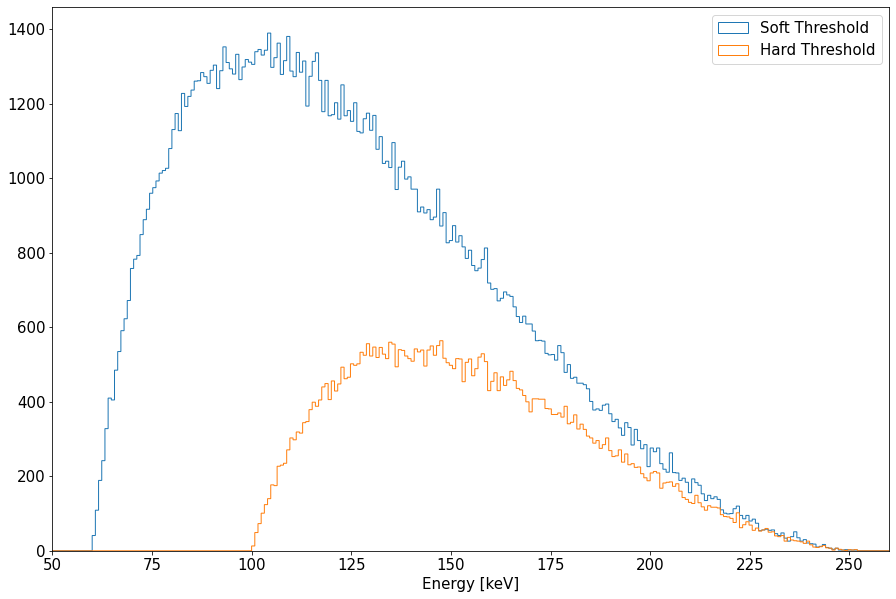

In [39]:
fs=15
t=b0Data.energy>30
softThresh=pd.coincident_pixel_energies(b0Data.energy[t],b0Data.timestamp[t],b0Data.board[t],b0Data.channel[t])
print('Done 1')
t=b0Data.energy>50
hardThresh=pd.coincident_pixel_energies(b0Data.energy[t],b0Data.timestamp[t],b0Data.board[t],b0Data.channel[t])

fig,ax=subplots(figsize=(15,10))
t=softThresh>0
ax.hist(softThresh[t],bins=nbins,range=rang,histtype='step',label='Soft Threshold')
t=hardThresh>0
ax.hist(hardThresh[t],bins=nbins,range=rang,histtype='step',label='Hard Threshold')
ax.legend(fontsize=fs)
ax.set_xlim(50,260)
ax.set_xlabel('Energy [keV]',fontsize=fs)
ax.tick_params(labelsize=fs)
show()

In [40]:
path='/run/media/nbirge/45Ca_data/cur_data/'
runs=[run for run in os.listdir(path) if run.endswith('all.npy')]
energyThreshold=30
runs.sort()
summed_energy=[]
beg=time.time()
for run in runs:
        data=np.load(path+run)
        data.sort(order='timestamp')
        data=data.view(np.recarray)

        pd.calibrate(data)
        t=data.energy>energyThreshold                #Energy Cut
        t=t*(data.t0>950)*(data.t0<1050)             #t0
        t=t*(data.timestamp*4e-9/3600<1)             #Removing bad timestamps

        summed_energy.append(pd.coincident_pixel_energies(data.energy[t],
                                                       data.timestamp[t],
                                                       data.board[t],
                                                       data.channel[t],
                                                       t_coincident=coincidenceWindow))
        print('\rfinished run '+run[4:-8]+' threshold= {threshold:d}keV in {time:0.2f} s'.format(threshold=int(energyThreshold),time=time.time()-beg),end='')
        sys.stdout.flush()
soft_summed_energy=np.concatenate(summed_energy)

finished run 79 threshold= 30keV in 1563.91 s

In [41]:
path='/run/media/nbirge/45Ca_data/cur_data/'
runs=[run for run in os.listdir(path) if run.endswith('all.npy')]
energyThreshold=50
runs.sort()
summed_energy=[]
beg=time.time()
for run in runs:
        data=np.load(path+run)
        data.sort(order='timestamp')
        data=data.view(np.recarray)

        pd.calibrate(data)
        t=data.energy>energyThreshold                #Energy Cut
        t=t*(data.t0>950)*(data.t0<1050)             #t0
        t=t*(data.timestamp*4e-9/3600<1)             #Removing bad timestamps

        summed_energy.append(pd.coincident_pixel_energies(data.energy[t],
                                                       data.timestamp[t],
                                                       data.board[t],
                                                       data.channel[t],
                                                       t_coincident=coincidenceWindow))
        print('\rfinished run '+run[4:-8]+' threshold= {threshold:d}keV in {time:0.2f} s'.format(threshold=int(energyThreshold),time=time.time()-beg),end='')
        sys.stdout.flush()
hard_summed_energy=np.concatenate(summed_energy)

finished run 79 threshold= 50keV in 797.58 ss

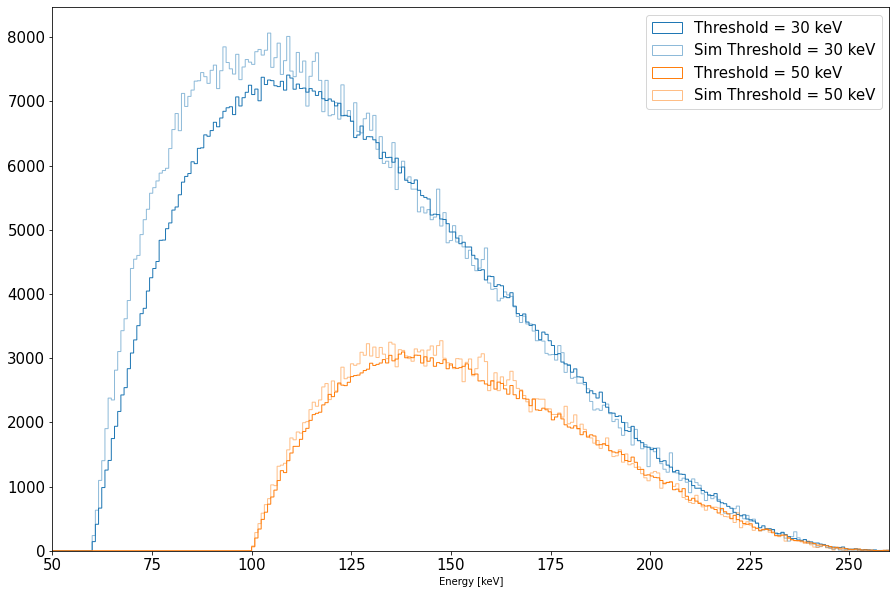

In [59]:
fig,ax=subplots(figsize=(15,10))
t=soft_summed_energy>0
ax.hist(soft_summed_energy[t],bins=nbins,range=rang,histtype='step',label='Threshold = 30 keV')
t=softThresh>0
ax.hist(softThresh[t],bins=nbins,range=rang,histtype='step',label='Sim Threshold = 30 keV',color='C0',
        alpha=0.5,weights=5.8*np.ones(np.sum(t)))
t=hard_summed_energy>0
ax.hist(hard_summed_energy[t],bins=nbins,range=rang,histtype='step',label='Threshold = 50 keV')
t=hardThresh>0
ax.hist(hardThresh[t],bins=nbins,range=rang,histtype='step',label='Sim Threshold = 50 keV',color='C1',
        alpha=0.5,weights=5.8*np.ones(np.sum(t)))
ax.legend(fontsize=fs)
ax.set_xlim(50,260)
ax.set_xlabel('Energy [keV]')
ax.tick_params(labelsize=fs)
show()

In [22]:
with open('/home/noah/Desktop/large_analysis/ca_analysis/detector_response/detector_response.pickle','rb') as f:
    detector_response=pickle.load(f)               #Loading det. repsp. widths (gaussian smearing)
for bdch,sigma in detector_response.items():
    bd,ch=divmod(bdch,8)
    # Applying DRF to b0 simulation
    t=(b0Data.board==bd)*(b0Data.channel==ch)
    size=np.sum(t)
    b0Data.energy[t] +=np.random.normal(loc=0,scale=sigma,size=size)
    
    # Applying DRF to b1 simulation
    t=(b1Data.board==bd)*(b1Data.channel==ch)
    size=np.sum(t)
    b1Data.energy[t] +=np.random.normal(loc=0,scale=sigma,size=size)

Making simulation cuts

In [23]:
t=((b0Data.board==2)+(b0Data.board==5))*(b0Data.channel==1)     #Removes knowledge of events on 77W/E
t=np.logical_not(t)
t*=b0Data.energy>energyThreshold      #Energy cut
b0_summed_energy = pd.coincident_pixel_energies(b0Data.energy[t],
                                               b0Data.timestamp[t],
                                               b0Data.board[t],
                                               b0Data.channel[t],
                                               t_coincident=coincidenceWindow)


t=((b1Data.board==2)+(b1Data.board==5))*(b1Data.channel==1)     #Removes knowledge of events on 77W/E
t=np.logical_not(t)
t*=b1Data.energy>energyThreshold      #Energy cut
b1_summed_energy = pd.coincident_pixel_energies(b1Data.energy[t],
                                               b1Data.timestamp[t],
                                               b1Data.board[t],
                                               b1Data.channel[t],
                                               t_coincident=coincidenceWindow)


Reading in data

In [24]:
path='/home/noah/Desktop/large_analysis/ca_analysis/cur_data/'
runs=[run for run in os.listdir(path) if run.endswith('all.npy')]
runs.sort()
summed_energy=[]
beg=time.time()
for run in runs:
        data=np.load(path+run)
        data.sort(order='timestamp')
        data=data.view(np.recarray)

        pd.calibrate(data)
        t=data.energy>energyThreshold                #Energy Cut
        t=t*(data.t0>950)*(data.t0<1050)             #t0
        t=t*(data.timestamp*4e-9/3600<1)             #Removing bad timestamps

        summed_energy.append(pd.coincident_pixel_energies(data.energy[t],
                                                       data.timestamp[t],
                                                       data.board[t],
                                                       data.channel[t],
                                                       t_coincident=coincidenceWindow))
        print('\rfinished run '+run[4:-8]+' threshold= {threshold:d}keV in {time:0.2f} s'.format(threshold=int(energyThreshold),time=time.time()-beg),end='')
        sys.stdout.flush()
summed_energy=np.concatenate(summed_energy)

finished run 79 threshold= 50keV in 274.53 s

Making simulation & data energy spectra (histograms)

In [25]:
trutharray=b0_summed_energy>5 # Just removing zero'd events
b0Hist,bins=np.histogram(b0_summed_energy[trutharray],bins=nbins,
                           range=rang)
bins=pd.cbins(bins)

trutharray=b1_summed_energy>5 # Just removing zero'd events
b1Hist=np.histogram(b1_summed_energy[trutharray],bins=nbins,
                           range=rang)[0]

trutharray=summed_energy>5 # Just removing zero'd events
dataHist=np.histogram(summed_energy[trutharray],bins=nbins,
                           range=rang)[0]

#### Fitting simulation to data
$$N\left(w(b=0)+b\left[w(b=1)-w(b=0)\right]\right)$$

Sliding window (constant fit length)

In [31]:
beg,end=150,225
trutharray = (bins>beg)*(bins<end)


weights=np.sqrt(dataHist[trutharray])
weights[weights==0]=1
X=(trutharray,b0Hist,alpha*b1Hist)   # Independent values for curve_fit

pars,vrs=curve_fit(pd.fierz_fit,X,dataHist[trutharray],\
                  p0=[max(dataHist[trutharray]),0],sigma=weights,\
                   absolute_sigma=False,maxfev=1000000,ftol=1e-9)
#                       epsfcn=1e-9)

vrs=sqrt(diag(vrs))           #Sqrt of cov. mtx = errors

chisq=np.sum((dataHist[trutharray]-pd.fierz_fit(X,*pars))**2./dataHist[trutharray])/(np.sum(trutharray)-len(pars))
out=np.asarray([pars[1],vrs[1],pars[0],vrs[0],chisq,beg,end])
print(pars)
print(vrs)


[5.89799972 0.48845584]
[0.05162824 0.07633198]


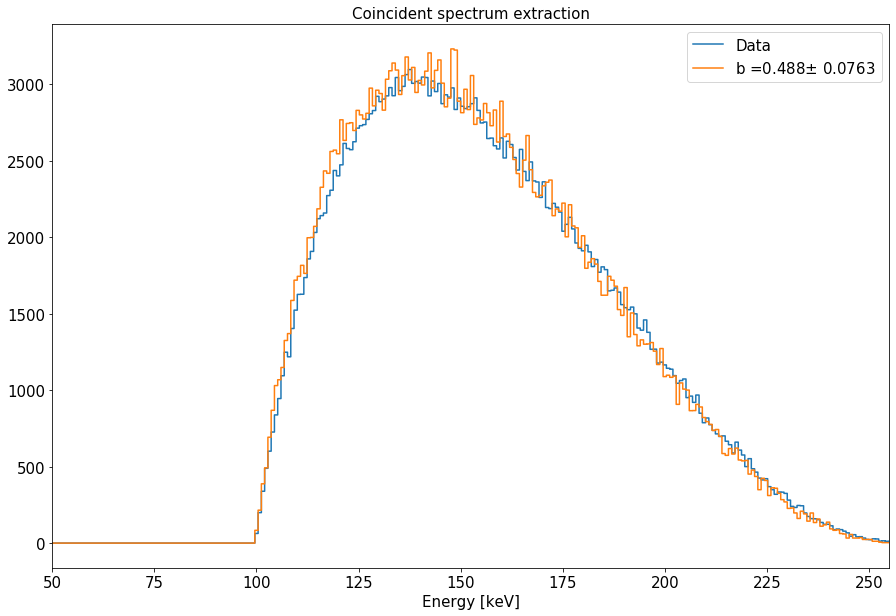

In [32]:
fs=15
trutharray=bins>-1
X=(trutharray,b0Hist,alpha*b1Hist)
fig,ax=subplots(figsize=(15,10))
ax.plot(bins,dataHist,ds='steps',label='Data')
ax.plot(bins,pd.fierz_fit(X,*pars),ds='steps',
        label=r'b ={b:0.3f}$\pm$ {berr:0.4f}'.format(b=pars[1],berr=vrs[1]))
# ax.plot(bins,pars[0]*b1Hist,ds='steps') 
ax.legend(fontsize=fs)
ax.tick_params(labelsize=fs)
ax.set_xlabel('Energy [keV]',fontsize=fs)
ax.set_title('Coincident spectrum extraction',fontsize=fs)
ax.set_xlim(50,255)
show()

In [ ]:

names='b,b_error,N,N_error,chisq,beg,end'
formats='f8,f8,f8,f8,f8,f8,f8'
b_vals=fromarrays(b_vals.T,names=names,formats=formats) # Converting to recarray for utility
b_vals=b_vals.view(recarray)
del names,formats
#np.save('b_vals-T_'+str(thresh),b_vals)
fs=30
fig,ax=subplots(nrows=2,ncols=2,figsize=(30,20))

for i in range(len(b_vals)):
    vals=b_vals[i]
    X=(np.ones(len(bins),dtype=bool),alpha0*b0_hist,alpha1*b1_hist)
#     if i%3==0:
    if vals.beg >0 and i%8==0:
        ax[0,0].plot(bins,pd.fierz_fit(X,vals.N,vals.b),ds='steps',label='b= {:0.2e} +/- {:0.3f}\nbeg: {:0d}'.format(vals.b,vals.b_error,int(vals.beg)))
        
# for i in range(len(b_vals)):
#     vals=b_vals[i]
#     X=(np.ones(len(bins),dtype=bool),b0_hist,b1_hist)
#     if i%3==0:
#     if vals.beg <110 and i%4==0:
#         ax[1,1].plot(bins,pd.fierz_fit(X,vals.N,vals.b),ds='steps',label='b= {:0.2e} +/- {:0.3f}\nbeg: {:0d}'.format(vals.b,vals.b_error,int(vals.beg)))        
text='Pixels included:\n'
for bdch in bdchs_of_interest:
    bd=int(bdch/8);ch=int(bdch%8)
    text+=pd.pixel(bd,ch)+'\n'
trutharray=b_vals.beg<=100
ax[0,0].plot(bins,d_hist,ds='steps',label='Data',lw=5)        
ax[0,0].legend(fontsize=fs-10)
ax[0,0].set_xlim(0,300)
ax[0,0].tick_params(labelsize=fs)
ax[0,0].set_title('Resulting Spectra',fontsize=fs)
ax[0,0].set_xlabel('Energy [keV]',fontsize=fs)
# ax[0,0].set_yscale('log')
ax[0,1].errorbar(b_vals.beg,b_vals.b,b_vals.b_error,fmt='o',\
                 label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.b[trutharray].mean())+': {:0.2f}'.format(b_vals.b[trutharray].std()))
# ax[0,1].errorbar(b_vals.beg,true_bs,true_b_err,fmt='o',\
#                  label='Mean: {:0.2f}\n'r'$\sigma$'.format(true_bs[trutharray].mean())+': {:0.2f}'.format(true_bs[trutharray].std()))
ax[0,1].legend(fontsize=fs)
ax[0,1].tick_params(labelsize=fs)
ax[0,1].set_xlabel('Beg. bin [keV]\n Note: windows end at  {:0d} keV'.format(end),fontsize=fs)
ax[0,1].set_xticks(arange(40,300,20))
ax[0,1].grid()
ax[0,1].set_ylabel('b',fontsize=fs)
ax[0,1].set_title('Fitted b values',fontsize=fs)
ax[0,1].set_ylim(0,2)
ax[0,1].set_xlim(90,220)
ax[1,0].errorbar(b_vals.beg,b_vals.N,b_vals.N_error,fmt='o',\
                 label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.N[trutharray].mean())+': {:0.2f}'.format(b_vals.N[trutharray].std()))
ax[1,0].legend(fontsize=fs)
ax[1,0].tick_params(labelsize=fs)
ax[1,0].set_xlabel('Beg. bin [keV]\n Note: windows end at  {:0d} keV'.format(end),fontsize=fs)
ax[1,0].set_ylabel('Normalization fit parameter',fontsize=fs)
ax[1,0].set_title('Normalization Fit Parameter',fontsize=fs)
ax[1,0].grid()
ax[1,1].plot(b_vals.beg,b_vals.chisq,marker='o',ls='None',\
             label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.chisq[trutharray].mean())+': {:0.2f}'.format(b_vals.chisq[trutharray].std()))
ax[1,1].legend(fontsize=fs)
ax[1,1].tick_params(labelsize=fs)
ax[1,1].set_xlabel('Beg. bin [keV]\n Note: windows end at  {:0d} keV'.format(end),fontsize=fs)
ax[1,1].set_ylabel(r'$\chi^2/\mathrm{DoF}$',fontsize=fs)
ax[1,1].set_title(r'$\chi^2/\mathrm{DoF}$',fontsize=fs)
ax[1,1].grid()
for i in range(1,4):
    row=int(i/2);col=int(i%2)
#     ax[row,col].set_xlim(150,300)
fig.text(0.525,0.5,text,fontsize=fs,fontweight='bold',horizontalalignment='center',verticalalignment='center')

fig.text(0.525,0.025,text,fontsize=fs,fontweight='bold',horizontalalignment='center',verticalalignment='center')
# ax[1].set_ylim(-2,2)
tight_layout()
print(b_vals.b[steps==150])
show()

## Varying the fit range

In [8]:
stepsize=0
end=220
beg=150
minb=1
maxb=0

# for beg in [steps[0]]:
for var_beg in arange(beg-4,beg+4):
    for var_end in arange(end-4,end+4):
        trutharray = ((bins>var_beg)*(bins<var_end))

        weights=np.sqrt(d_hist[trutharray])


        X=(trutharray,alpha0*b0_hist,alpha1*b1_hist)   # Independent values for curve_fit
    
        pars,vrs=curve_fit(pd.fierz_fit,X,d_hist[trutharray],\
                          p0=[d_hist[trutharray][0],0],sigma=weights,\
                           absolute_sigma=False,maxfev=1000000,ftol=1e-8)
    #                       epsfcn=1e-9)
        if pars[1]>maxb:
            maxb=pars[1]
        if pars[1]<minb:
            minb=pars[1]
t=steps==beg
print( maxb-b_vals.b[t][0],minb-b_vals.b[t][0])

0.05534617389653029 -0.03675236470097787


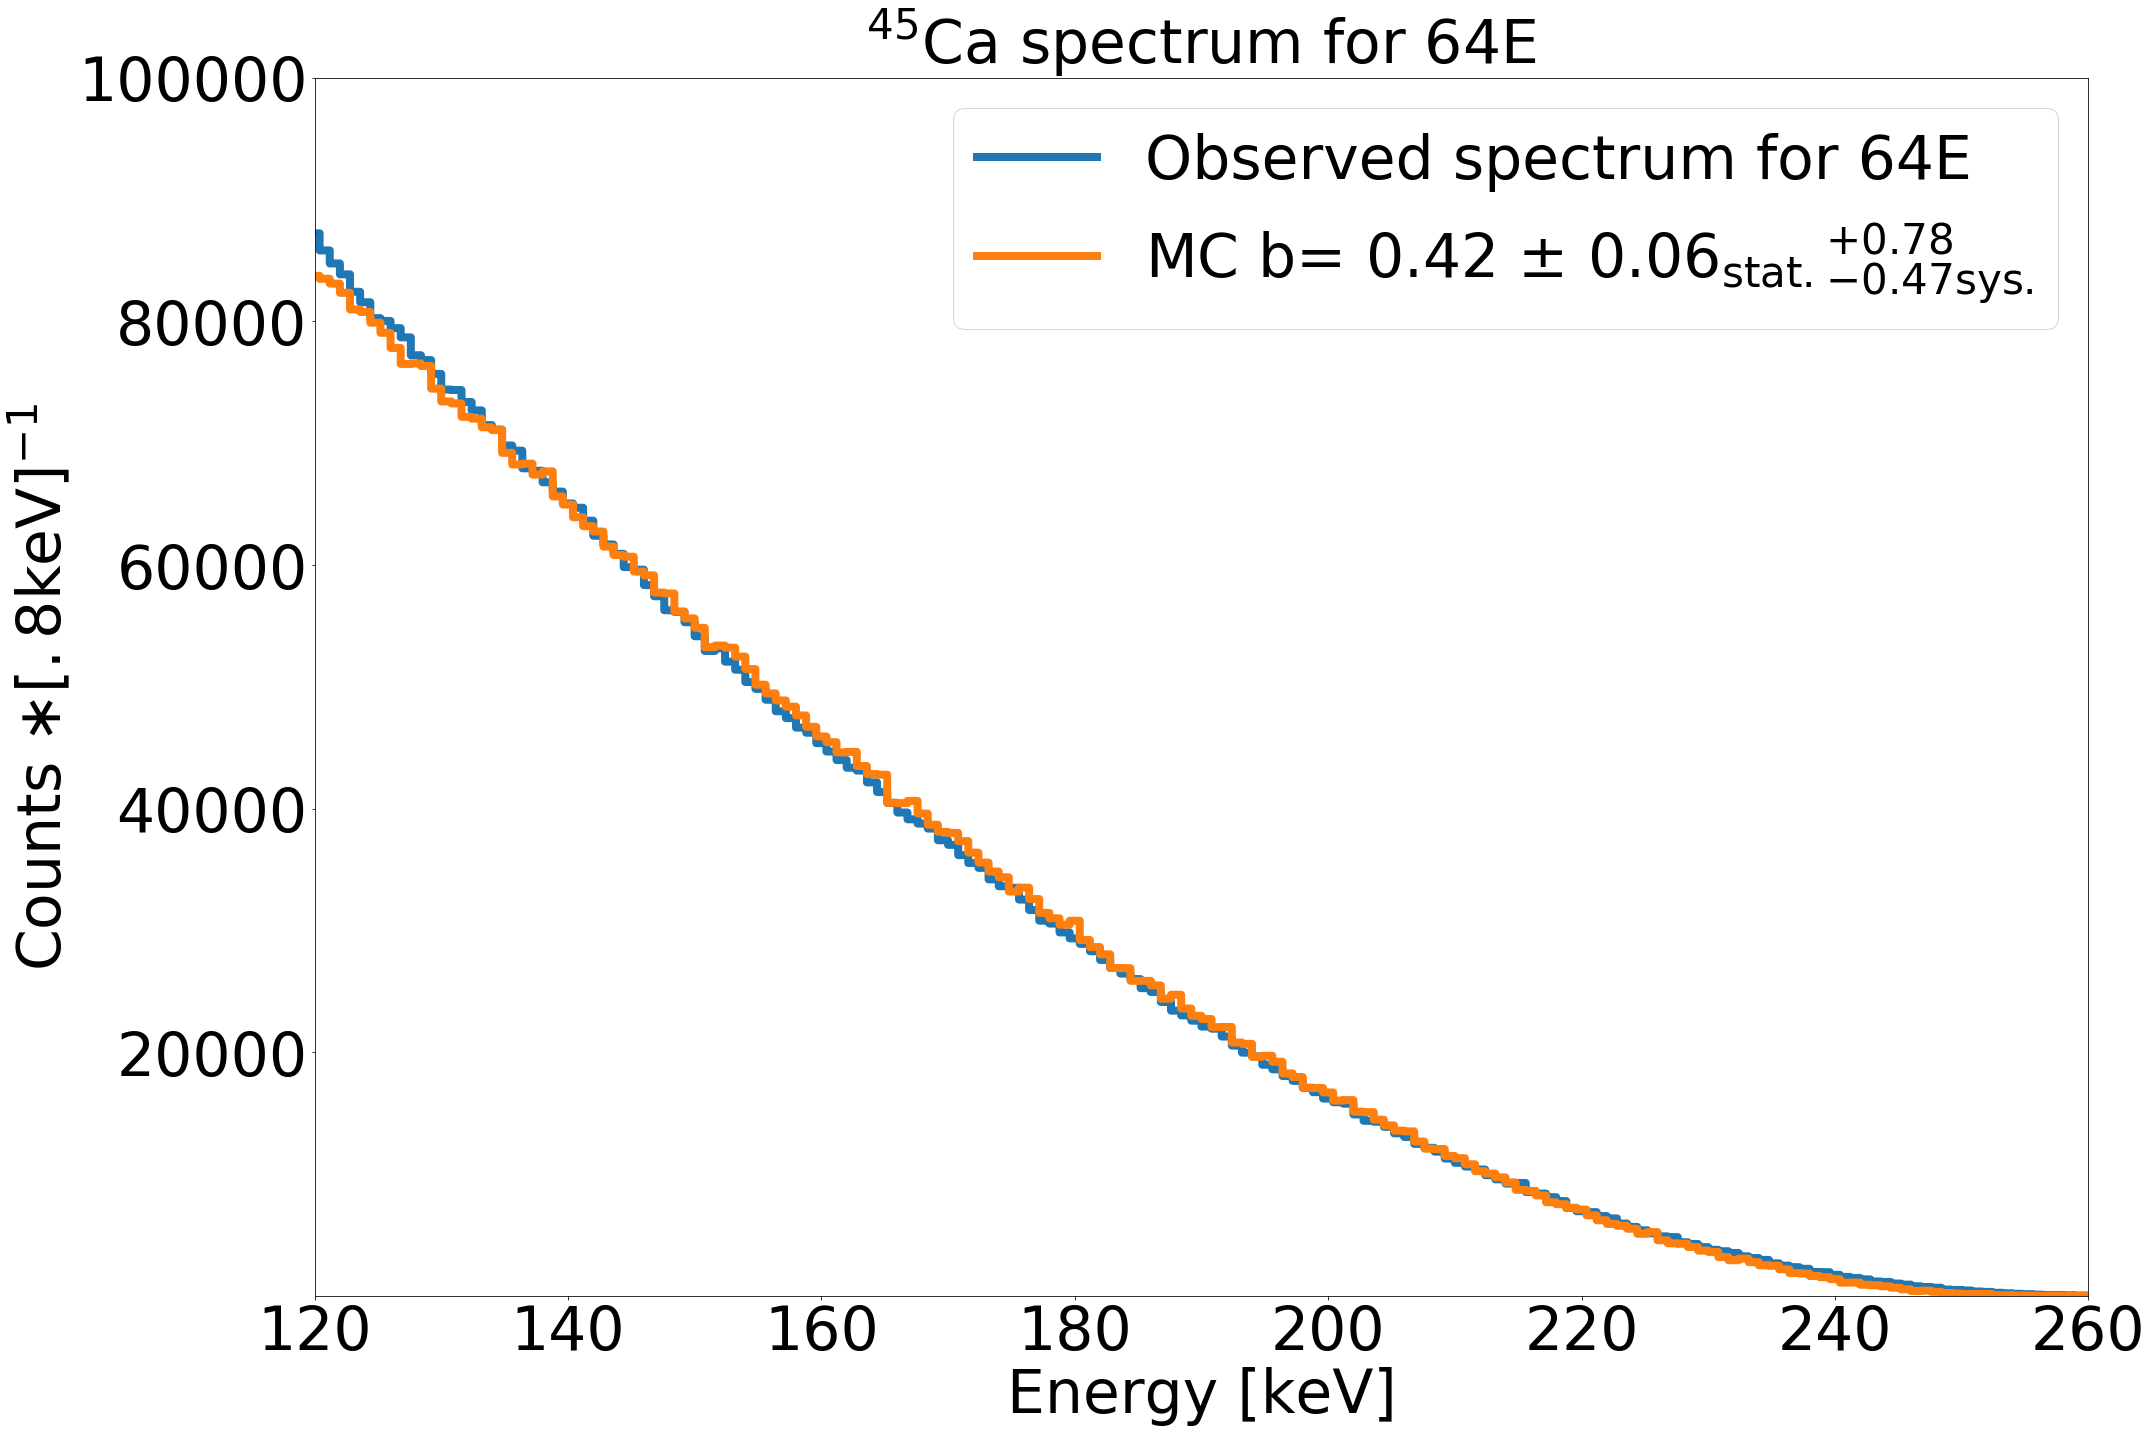

In [22]:
fs=53
b_vals=ndarray(shape=(0,7))    # b | b error | N | N error | X^2/DoF | begin. fit| end fit
stepsize=0
end=220
if 35 in bdchs_of_interest:
    steps=arange(100,end-10,2)
else:
    steps=arange(40,end-10,2)
true_bs=[]
true_b_err=[]

beg,end=150,220
trutharray=(bins>beg)*(bins<end)
weights=np.sqrt(d_hist[trutharray])
#     weights=sqrt(rel_uncert_data**2.+rel_uncert_sim**2.)*sqrt(d_hist[trutharray])

X=(trutharray,alpha0*b0_hist,alpha1*b1_hist)   # Independent values for curve_fit
    
pars,vrs=curve_fit(pd.fierz_fit,X,d_hist[trutharray],\
                  p0=[d_hist[trutharray][0],0],sigma=weights,\
                   absolute_sigma=False,maxfev=1000000,ftol=1e-8)
#                       epsfcn=1e-9)

vrs=sqrt(diag(vrs))           #Sqrt of cov. mtx = errors
fig,ax=subplots(figsize=(30,20))
lw=8;fs=60
ax.plot(bins,d_hist,ds='steps',label='Observed spectrum for '+pd.pixel(bd,ch),lw=lw)
X=(np.ones(len(bins),dtype=bool),alpha0*b0_hist,alpha1*b1_hist)
ax.plot(bins,pd.fierz_fit(X,vals.N,vals.b),ds='steps',lw=lw,label='MC b= {:0.2f}'.format(pars[1])+
        r' $\pm$'+' {:0.2f}'.format(vrs[1])+r'$_\mathrm{stat.} {}^{+0.78}_{-0.47 \mathrm{sys.}}$')
ax.legend(fontsize=fs)
ax.set_xlim(0,300)
ax.tick_params(labelsize=fs)
ax.set_ylabel(r'Counts $\ast [.8 \mathrm{keV}]^{-1}$',fontsize=fs)
ax.set_title(r'$^{45}\mathrm{Ca}$ spectrum for '+pd.pixel(bd,ch),fontsize=fs)
ax.set_xlabel('Energy [keV]',fontsize=fs)
ax.set_xlim(120,260)
ax.set_ylim(1,1e5)
fig.tight_layout()
savefig('/home/noah/Desktop/calcium_spectrum-'+pd.pixel(bd,ch)+'.png')
# savefig('/home/noah/Desktop/phd/ut-thesis/figures/pdf/calcium_spectrum-'+pd.pixel(bd,ch)+'.pdf',format='pdf')
show()